## Experiments - May 20, 2022


Hyperparam choices:

Criterion = CrossEntropyLoss  
Optimizer = SGD
lr = 1e-4
<!-- num_epochs = 400-600 depending on what it takes to converge   -->
Random split generator seeded: 73    
batch_size = 10
<!-- 
### methods
- [benchmarks](#benchmarks)
- [plots](#plots)
- [model args](#args) -->
  

### [Global Image](#1.1)
1. unweighted 
    - 1.1 [Base CNN - scaled down to 28x28](#1.1)
    - 1.2 [ResNet - scaled down to 212x212](#1.2)

2. weighted sample
    - 2.1 [Base CNN - scaled  down to 28x28](#2.1)
    - 2.2 [ResNet - scaled down to 212x212](#2.2)

### [Local ROI](#3.1)
3. unweighted
    - 3.1 [Base CNN - cropped 28x28 roi](#3.1)
    - 3.2 [ResNet - roi interpolated/scaled up to 212x212](#3.2)

4. weighted sampling
    - 4.1 [Base CNN - cropped 28x28 roi](#4.1)
    - 4.2 [ResNet - roi interpolated/scaled up to 212x212](#4.2)


Experiments TBD - cnn-lstm. factors are weighted sampling +/-, sequence length like 1-50, can swap in resnet or pretrain some.




In [1]:
import os
import torch
from cnn_driver import train, test, get_dataloaders, get_deep_features
from parsing_utils import make_parser
from models import BaseCNN, VGG_Model, ResNet18, ResBlock

from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
import pickle
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE



/home/rachel/anaconda3/envs/ornet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### benchmarks
<a id='benchmarks'></a>


In [2]:
def run_benchmarks(path_to_features):

    with open(path_to_features, 'rb') as f:
        feature_df = pickle.load(f)

    X = feature_df.iloc[:, :-1]
    y = feature_df['label']

    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2,  random_state=73, shuffle=True, stratify=None)

    clf = RandomForestClassifier(max_depth=3, random_state=0)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy = np.sum(pred == y_test) / len(y_test)
    print("RF accuracy:", accuracy)
    cm = confusion_matrix(pred, y_test)
    print(cm)

    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy = np.sum(pred == y_test) / len(y_test)
    print("KNN accuracy", accuracy)
    cm = confusion_matrix(pred, y_test)
    print(cm)

    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy = np.sum(pred == y_test) / len(y_test)
    print("Decision Tree Accuracy", accuracy)
    cm = confusion_matrix(pred, y_test)
    print(cm)

    return


<a id='plots'></a>

In [3]:

def plot_losses(path):
    print(path)
    with open(path, 'rb') as f:
        d = pickle.load(f)

    t = d["train_loss"]
    v = d["val_loss"]
    plt.plot(t, '-o')
    plt.plot(v, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim((0, 2))
    plt.legend(['Train', 'Valid'])
    plt.title('Train vs Valid Accuracy')


<a id='args'></a>

In [9]:
class JupyterArgs:
    def __init__(self):
        self.batch_size = 10
        self.roi = False
        self.weighted_samples = False
        self.cuda = -1
        self.lr = 1e-3
        self.epochs = 300
        self.classes = ['control', 'mdivi', 'llo']
        self.input_dir = "/data/ornet/single_cells_cnns"
        # self.save = True
        self.save_dir = "/home/rachel/ornet/models/"
        self.save_as = "model1.pth"
        self.train = True
        # self.get_features = "/home/rachel/ornet/representations/"
        self.get_features = False
        self.get_losses = "/home/rachel/ornet/losses/"


args = JupyterArgs()


In [10]:
"""
we have more segmented cell videos saved on logan then intermediates.
best to rerun ornet on raw data, but till discrepancy is resolved this
will result in using the 114 samples that Neelima used in the last scipy submit
class balance 29, 31, 54
"""
path_to_intermediates = "/data/ornet/gmm_intermediates"
accept_list = []
for subdir in args.classes:
    path = os.path.join(path_to_intermediates, subdir)
    for file in os.listdir(path):
        if 'normalized' in file:
            accept_list.append(file.split(".")[0])

device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device = torch.device(device)


In [11]:
root_dir = "/home/rachel/ornet/"
device


device(type='cuda')

### Global image

<a id='1.1'></a>
1.1

Using global image inputs
/data/ornet/single_cells_cnns
Training


epochs: 100%|██████████| 5000/5000 [14:33<00:00,  5.72it/s]


saving loss plots
Getting deep features
best performance at epoch 3238
/home/rachel/ornet/losses/global_BaseCNN_unweighted_v3.pkl
Best model at epoch 3238
Testing
Accuracy: tensor(0.5833, device='cuda:0')
['control', 'mdivi', 'llo']
[[0 0 3]
 [0 2 2]
 [0 0 5]]
Running benchmarks on deep representation
RF accuracy: 0.8484848484848485
[[11  0  2]
 [ 2  8  0]
 [ 1  0  9]]
KNN accuracy 0.8787878787878788
[[12  0  2]
 [ 2  8  0]
 [ 0  0  9]]
Decision Tree Accuracy 0.7575757575757576
[[11  1  2]
 [ 2  7  2]
 [ 1  0  7]]


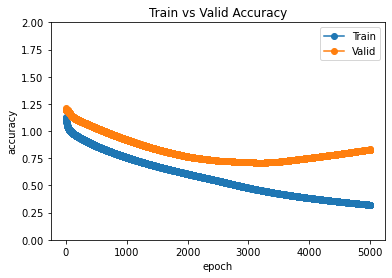

In [12]:
# 1.1
# args.save_features = os.path.join(
#     root_dir, "representations/global_BaseCNN_unweightedl")
# args.save_model = os.path.join(
#     root_dir, "models/global_BaseCNN_unweightedh")
# args.save_losses = os.path.join(
#     root_dir, "losses/global_BaseCNN_unweightedl")

args.save_features = os.path.join(
    root_dir, "representations/global_BaseCNN_unweighted_v3.pkl")
args.save_model = os.path.join(
    root_dir, "models/global_BaseCNN_unweighted_v3.pth")
args.save_losses = os.path.join(
    root_dir, "losses/global_BaseCNN_unweighted_v3.pkl")

args.roi = False
args.weighted_samples = False
args.epochs = 5000
args.lr = 1e-4

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

model = BaseCNN()
# model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)


Using global image inputs
/data/ornet/single_cells_cnns
Getting deep features
best performance at epoch 181
/home/rachel/ornet/losses/global_BaseCNN_unweighted_05-19_v2.pkl
Best model at epoch 181
Testing
Accuracy: tensor(0.6667, device='cuda:0')
['control', 'mdivi', 'llo']
[[1 0 2]
 [0 3 1]
 [1 0 4]]
Running benchmarks on deep representation
RF accuracy: 0.7272727272727273
[[10  0  3]
 [ 3  6  0]
 [ 1  2  8]]
KNN accuracy 0.8484848484848485
[[12  1  2]
 [ 1  7  0]
 [ 1  0  9]]
Decision Tree Accuracy 0.8484848484848485
[[10  0  0]
 [ 3  7  0]
 [ 1  1 11]]


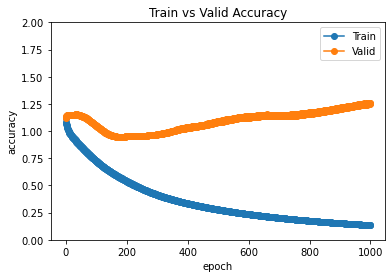

In [29]:
# # 1.1
# # args.save_features = os.path.join(
# #     root_dir, "representations/global_BaseCNN_unweighted_05-19.pkl")
# # args.save_model = os.path.join(
# #     root_dir, "models/global_BaseCNN_unweighted_05-19.pth")
# # args.save_losses = os.path.join(
# #     root_dir, "losses/global_BaseCNN_unweighted_05-19.pkl")

# args.save_features = os.path.join(
#     root_dir, "representations/global_BaseCNN_unweighted_v3.pkl")
# args.save_model = os.path.join(
#     root_dir, "models/global_BaseCNN_unweighted_v3.pth")
# args.save_losses = os.path.join(
#     root_dir, "losses/global_BaseCNN_unweighted_v3.pkl")

# args.roi = False
# args.weighted_samples = False
# args.epochs = 4000
# args.lr = 1e-4

# train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
#     args, accept_list, resize=28)

# model = BaseCNN()
# # model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
# model.to(device)

# if args.train:
#     print("Training")
#     train(args, model, train_dataloader, val_dataloader, device=device)

# get_deep_features(args, model, [train_dataloader,
#                   test_dataloader, val_dataloader], device=device)

# plot_losses(args.save_losses)

# checkpoint = torch.load(args.save_model)
# model.load_state_dict(checkpoint['state_dict'])
# print("Best model at epoch", checkpoint['epoch'])
# print("Testing")
# test(args, model, test_dataloader, device=device)

# print("Running benchmarks on deep representation")
# run_benchmarks(args.save_features)


<a id='1.2'></a>
1.2

Using global image inputs
/data/ornet/single_cells_cnns
Training


epochs: 100%|██████████| 1000/1000 [15:16<00:00,  1.09it/s]


saving loss plots
Getting deep features
best performance at epoch 115
/home/rachel/ornet/losses/global_ResNet_unweighted.pkl
Best model at epoch 115
Testing
Accuracy: tensor(0.6667, device='cuda:0')
['control', 'mdivi', 'llo']
[[1 0 2]
 [0 2 2]
 [0 0 5]]
Running benchmarks on deep representation
RF accuracy: 0.9696969696969697
[[14  0  1]
 [ 0  8  0]
 [ 0  0 10]]
KNN accuracy 0.9090909090909091
[[13  0  2]
 [ 1  8  0]
 [ 0  0  9]]
Decision Tree Accuracy 0.9393939393939394
[[14  0  2]
 [ 0  8  0]
 [ 0  0  9]]


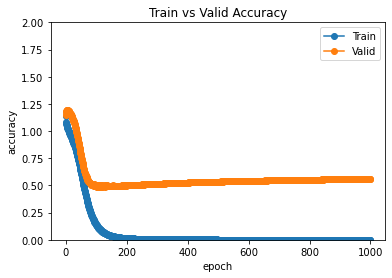

In [13]:
# 1.2
args.save_model = os.path.join(
    root_dir, "models/global_ResNet_unweighted.pth")
args.save_features = os.path.join(
    root_dir, "representations/global_ResNet_unweighted.pkl")
args.save_losses = os.path.join(
    root_dir, "losses/global_ResNet_unweighted.pkl")

args.roi = False
args.weighted_samples = False
args.epochs = 1000
args.lr = 1.5e-3

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)


<a id='2.1'></a>
2.1

Using global image inputs
/data/ornet/single_cells_cnns
using weighted sampling
Training


epochs: 100%|██████████| 5000/5000 [14:10<00:00,  5.88it/s]


saving loss plots
Getting deep features
best performance at epoch 1002
/home/rachel/ornet/losses/global_BaseCNN_weighted.pkl
Best model at epoch 1002
Testing
Accuracy: tensor(0.4167, device='cuda:0')
['control', 'mdivi', 'llo']
[[1 0 2]
 [0 2 2]
 [3 0 2]]
Running benchmarks on deep representation
RF accuracy: 0.8461538461538461
[[ 6  0  1]
 [ 1 10  0]
 [ 2  0  6]]
KNN accuracy 0.6923076923076923
[[7 3 2]
 [0 6 0]
 [2 1 5]]
Decision Tree Accuracy 0.8461538461538461
[[8 3 0]
 [1 7 0]
 [0 0 7]]


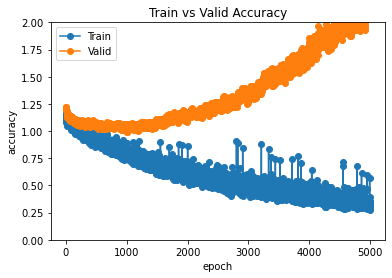

In [14]:
# 2.1
#does this need rerun
args.save_features = os.path.join(
    root_dir, "representations/global_BaseCNN_weighted.pkl")
args.save_model = os.path.join(
    root_dir, "models/global_BaseCNN_weighted.pth")
args.save_losses = os.path.join(
    root_dir, "losses/global_BaseCNN_weighted.pkl")

args.weighted_samples = True
args.roi = False
args.lr = 1e-4
args.epochs = 5000

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

model = BaseCNN()
# model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)


if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)


<a id='2.2'></a>
2.2

Using global image inputs
/data/ornet/single_cells_cnns
using weighted sampling
Training


epochs: 100%|██████████| 1000/1000 [15:30<00:00,  1.07it/s]


saving loss plots
Getting deep features
best performance at epoch 969
/home/rachel/ornet/losses/global_ResNet_weighted_v3.pkl
Best model at epoch 969
Testing
Accuracy: tensor(0.7500, device='cuda:0')
['control', 'mdivi', 'llo']
[[2 0 1]
 [0 4 0]
 [2 0 3]]
Running benchmarks on deep representation
RF accuracy: 0.9166666666666666
[[10  0  0]
 [ 0  8  0]
 [ 2  0  4]]
KNN accuracy 0.9166666666666666
[[11  0  1]
 [ 0  8  0]
 [ 1  0  3]]
Decision Tree Accuracy 0.875
[[9 0 0]
 [0 8 0]
 [3 0 4]]


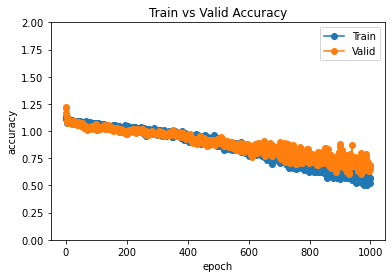

In [18]:
# 2.2
args.save_features = os.path.join(
    root_dir, "representations/global_ResNet_weighted_v3.pkl")
args.save_model = os.path.join(
    root_dir, "models/global_ResNet_weighted_v3.pth")
args.save_losses = os.path.join(
    root_dir, "losses/global_ResNet_weighted_v3.pkl")

args.weighted_samples = True
args.roi = False
args.lr = 1e-4
args.epochs = 1000

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)


if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)


########

### ROI Image
<a id='3.1'></a>
3.1

Using ROI inputs
/data/ornet/single_cells_cnns
Training


epochs: 100%|██████████| 5000/5000 [44:51<00:00,  1.86it/s]


saving loss plots
Getting deep features
best performance at epoch 1789
/home/rachel/ornet/losses/roi_BaseCNN_unweighted_v3.pkl
Best model at epoch 1789
Testing
Accuracy: tensor(0.5000, device='cuda:0')
['control', 'mdivi', 'llo']
[[1 1 1]
 [1 0 3]
 [0 0 5]]
Running benchmarks on deep representation
RF accuracy: 0.9393939393939394
[[13  0  0]
 [ 0  7  0]
 [ 1  1 11]]
KNN accuracy 0.8787878787878788
[[13  0  1]
 [ 0  7  1]
 [ 1  1  9]]
Decision Tree Accuracy 0.9393939393939394
[[14  0  0]
 [ 0  7  1]
 [ 0  1 10]]


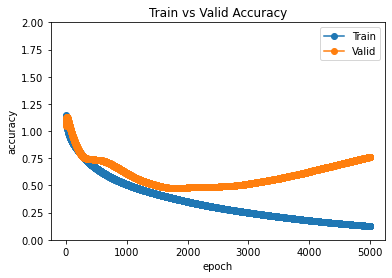

In [19]:
# 3.1
args.save_model = os.path.join(
    root_dir, "models/roi_BaseCNN_unweighted_v3.pth")
args.save_features = os.path.join(
    root_dir, "representations/roi_BaseCNN_unweighted_v3.pkl")
args.save_losses = os.path.join(
    root_dir, "losses/roi_BaseCNN_unweighted_v3.pkl")

args.roi = True
args.weighted_samples = False
args.lr = 1e-4
args.epochs = 5000

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

model = BaseCNN()
# model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)


<a id='3.2'></a>
3.2

Using ROI inputs
/data/ornet/single_cells_cnns
Training


epochs: 100%|██████████| 1000/1000 [21:15<00:00,  1.28s/it]


saving loss plots
Getting deep features
best performance at epoch 297
/home/rachel/ornet/losses/roi_ResNet_unweighted_v3.pkl
Best model at epoch 297
Testing
Accuracy: tensor(0.6667, device='cuda:0')
['control', 'mdivi', 'llo']
[[2 0 1]
 [1 1 2]
 [0 0 5]]
Running benchmarks on deep representation
RF accuracy: 0.6363636363636364
[[7 2 1]
 [3 5 1]
 [4 1 9]]
KNN accuracy 0.7878787878787878
[[11  3  1]
 [ 3  5  0]
 [ 0  0 10]]
Decision Tree Accuracy 0.5454545454545454
[[6 1 3]
 [5 5 1]
 [3 2 7]]


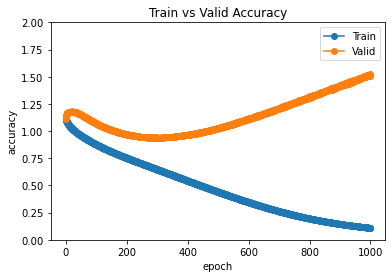

In [17]:
# 3.2
args.save_model = os.path.join(
    root_dir, "models/roi_ResNet_unweighted_v3.pth")
args.save_features = os.path.join(
    root_dir, "representations/roi_ResNet_unweighted_v3.pkl")
args.save_losses = os.path.join(
    root_dir, "losses/roi_ResNet_unweighted_v3.pkl")

# well this is crap at higher and lower lr

args.roi = True
args.weighted_samples = False
args.lr = 1e-4
args.epochs = 1000

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)


In [36]:
torch.cuda.is_available()
## start here rchel 

True

<a id='4.1'></a>
4.1

Using ROI inputs
/data/ornet/single_cells_cnns
using weighted sampling
Training


epochs: 100%|██████████| 5000/5000 [44:39<00:00,  1.87it/s]


saving loss plots
Getting deep features
best performance at epoch 4727
/home/rachel/ornet/losses/roi_BaseCNN_weighted_v3.pkl
Best model at epoch 4727
Testing
Accuracy: tensor(0.4167, device='cuda:0')
['control', 'mdivi', 'llo']
[[0 2 1]
 [1 1 2]
 [1 0 4]]
Running benchmarks on deep representation
RF accuracy: 0.8888888888888888
[[ 7  1  0]
 [ 1 10  0]
 [ 1  0  7]]
KNN accuracy 0.9259259259259259
[[ 8  1  0]
 [ 0 10  0]
 [ 1  0  7]]
Decision Tree Accuracy 0.8888888888888888
[[ 7  1  0]
 [ 2 10  0]
 [ 0  0  7]]


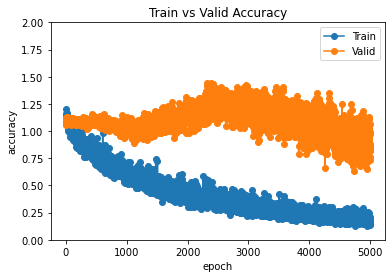

In [20]:
# 4.1
args.save_features = os.path.join(
    root_dir, "representations/roi_BaseCNN_weighted_v3.pth")
args.save_model = os.path.join(
    root_dir, "models/roi_BaseCNN_weighted_v3.pkl")
args.save_losses = os.path.join(
    root_dir, "losses/roi_BaseCNN_weighted_v3.pkl")

args.roi = True
args.weighted_samples = True
args.lr = 1e-4
args.epochs = 5000


train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

model = BaseCNN()
# model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)


<a id='4.2'></a>
4.2

Using ROI inputs
/data/ornet/single_cells_cnns
using weighted sampling
Training


epochs: 100%|██████████| 1000/1000 [21:16<00:00,  1.28s/it]


saving loss plots
Getting deep features
best performance at epoch 325
/home/rachel/ornet/losses/roi_ResNet_weighted_v3.pkl
Best model at epoch 325
Testing
Accuracy: tensor(0.6667, device='cuda:0')
['control', 'mdivi', 'llo']
[[3 0 0]
 [0 1 3]
 [1 0 4]]
Running benchmarks on deep representation
RF accuracy: 0.84
[[ 6  1  0]
 [ 0 10  1]
 [ 0  2  5]]
KNN accuracy 0.92
[[ 6  1  0]
 [ 0 12  1]
 [ 0  0  5]]
Decision Tree Accuracy 0.8
[[6 1 0]
 [0 9 1]
 [0 3 5]]


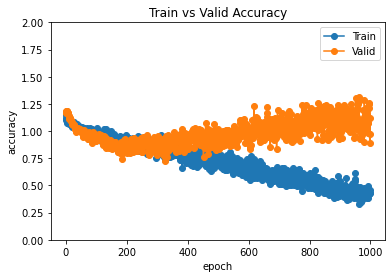

In [21]:
# 4.2
args.save_features = os.path.join(
    root_dir, "representations/roi_ResNet_weighted_v3.pkl")
args.save_model = os.path.join(
    root_dir, "models/roi_ResNet_weighted_v3.pth")
args.save_losses = os.path.join(
    root_dir, "losses/roi_ResNet_weighted_v3.pkl")

args.roi = True
args.weighted_samples = True
args.lr = 1e-4
args.epochs = 1000

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)


if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

get_deep_features(args, model, [train_dataloader,
                  test_dataloader, val_dataloader], device=device)

plot_losses(args.save_losses)

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Best model at epoch", checkpoint['epoch'])
print("Testing")
test(args, model, test_dataloader, device=device)

print("Running benchmarks on deep representation")
run_benchmarks(args.save_features)
